In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

In [2]:
file_path = "../../df_naive_impute.csv"
# df = pd.read_csv(file_path, skiprows=[1])
df = pd.read_csv(file_path)

In [3]:
df.columns, len(df.columns)

(Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
        'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
        'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
        'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
        'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
        'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
        'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id'],
       dtype='object'),
 29)

In [4]:
# naive mode definition
df["POWER_1"] = df["POWER_1"].astype(float)
df["POWER_2"] = df["POWER_2"].astype(float)
df["STW"] = df["STW"].astype(float)
df["STW_diff"] = abs(df["STW"] - df["STW"].shift(periods=-1, fill_value=100))

# MODE for operation mode: 1 for mode1, 2 for mode2, 0 for unknown(power with nan)
def naive_operation_mode(row):
    if pd.isna(row['POWER_1']) or (pd.isna(row["POWER_2"])):
        return 0
    elif (~((row["POWER_1"]<=800) ^ (row["POWER_2"]<=800))) | (row["STW"]<=16) | (row["STW_diff"]>=1):
        return 2
    else:
        return 1

df["MODE"] = df[["POWER_1", "POWER_2", "STW", "STW_diff"]].apply(naive_operation_mode, axis=1)
df.drop("STW_diff", axis=1, inplace=True)

In [5]:
def correct_mode(row):
    if (row["MODE"]==1):
        if row["trip_id"]==0:
            return 2
    return row["MODE"]

def clean_mode(row):
    if row["MODE_up"] == row["MODE_down"]:
        if row["MODE"]!=row["MODE_up"]:
            return row["MODE_up"]
    return row["MODE"]

df["MODE"] = df[["MODE", "STW", "DEPTH", "trip_id"]].apply(correct_mode,axis=1)
df["MODE_up"] = df["MODE"].shift(periods=-1)
df["MODE_down"] = df["MODE"].shift(periods=1)
df["MODE"] = df[["MODE", "MODE_up", "MODE_down"]].apply(clean_mode,axis=1)
df.drop(["MODE_up", "MODE_down"],axis=1, inplace=True)

In [ ]:
df[df.trip_id==1119][["SPEED_1", "SPEED_2", "STW", "MODE"]].to_csv("tmp.csv", index=False)

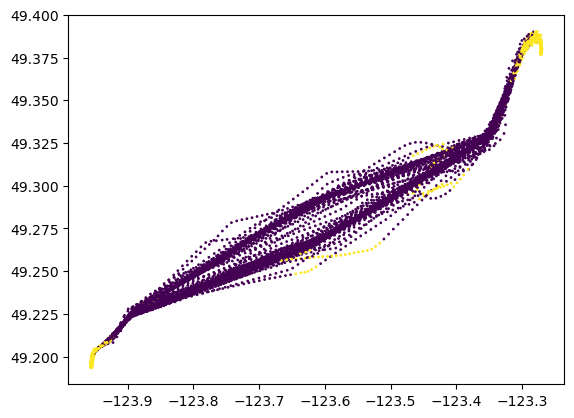

In [ ]:
samples = df.trip_id.sample(100)
plt.scatter(df[df.trip_id.isin(samples)].LONGITUDE, df[df.trip_id.isin(samples)].LATITUDE, c = df[df.trip_id.isin(samples)].MODE, s=1)

In [10]:
df.groupby("MODE").count()

,Dati,Time,DEPTH,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,HEADING,LATITUDE,LONGITUDE,...,STW,THRUST_1,THRUST_2,TORQUE_1,TORQUE_2,WIND_ANGLE,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,trip_id
MODE,,,,,,,,,,,,,,,,,,,,,
1.0,271017,271017,271017,271017,271017,271017,271017,271017,271017,271017,...,271017,271017,271017,271017,271017,271017,271017,271017,271017,271017
2.0,53238,53238,53238,53238,53238,53238,53238,53238,53238,53238,...,53238,53238,53238,53238,53238,53238,53238,53238,53238,53238


In [6]:
# from the Dati variable, get the corresponding season code, hour, and day of the week
def get_dt_info(minute, starting_dt):
    dt = starting_dt + datetime.timedelta(minutes=minute) # days, seconds, then other fields.
    month = dt.month
    season = get_season(month)
    hour = dt.hour
    weekday = dt.weekday()
    return dt, season, hour, weekday

# get season code from corresponding month:
# spring: 0, summer: 1, fall: 2, winter: 3
def get_season(month):
    if month <= 3:
        return 3
    elif month <=6:
        return 0
    elif month <=9:
        return 1
    else:
        return 2

# convert Dati to python datetime format
# df["datetime"] = pd.to_datetime(df.Dati, format='%y%m%d_%H%M%S')
# df.dropna(subset = ["Time"], inplace=True)
starting_dt = pd.to_datetime(df.iloc[0].Dati, format='%y%m%d_%H%M%S')
df["datetime"],df["season"], df["hour"], df["weekday"] = zip(*df["Time"].apply(get_dt_info, starting_dt = starting_dt))
df[["datetime", "season", "hour", "weekday"]]

,datetime,season,hour,weekday
0,2019-08-30 04:54:00,1,4,4
1,2019-08-30 04:55:00,1,4,4
2,2019-08-30 04:56:00,1,4,4
3,2019-08-30 04:57:00,1,4,4
4,2019-08-30 04:58:00,1,4,4
...,...,...,...,...
324250,2021-10-01 00:34:00,2,0,4
324251,2021-10-01 00:35:00,2,0,4
324252,2021-10-01 00:36:00,2,0,4
324253,2021-10-01 00:37:00,2,0,4


In [7]:
# current: difference between STW and SOG
df["current"] = df["STW"] - df["SOG"]
# df.current

In [8]:
# # Horseshoe Bay
# # 49.3771, -123.2715
# H_lat = 49.3771
# H_long = -123.2715

# # Nanaimo 
# # 49.1936, -123.9554
# N_lat = 49.1936
# N_long = -123.9554

In [9]:
def get_direction():
    trips = list(df.trip_id.unique())
    # trip 0 (parking) has direction 0
    direction_dict = {}
    direction_dict[0] = "parking"
    for trip in trips:
        tmp_df = df[df.trip_id==trip].reset_index()
        if (tmp_df.iloc[-1].LONGITUDE > tmp_df.iloc[0].LONGITUDE) & (tmp_df.iloc[-1].LATITUDE > tmp_df.iloc[0].LATITUDE):
            direction_dict[trip]="N-H"
        elif (tmp_df.iloc[-1].LONGITUDE < tmp_df.iloc[0].LONGITUDE) & (tmp_df.iloc[-1].LATITUDE < tmp_df.iloc[0].LATITUDE):
            direction_dict[trip]="H-N"
        else:
            print("error occurs when classifying trip {}".format(trip))
    return direction_dict

In [10]:
direcs_dict = get_direction()
df["direction"] = df["trip_id"].apply(lambda x: direcs_dict[x])
df.groupby("direction").count()

,Dati,Time,DEPTH,ENGINE_1_FLOWTEMPA,ENGINE_1_FUEL_CONSUMPTION,ENGINE_2_FLOWTEMPA,ENGINE_2_FUEL_CONSUMPTION,HEADING,LATITUDE,LONGITUDE,...,WIND_SPEED,WIND_ANGLE_TRUE,WIND_SPEED_TRUE,trip_id,MODE,datetime,season,hour,weekday,current
direction,,,,,,,,,,,,,,,,,,,,,
H-N,115157,115157,115157,115157,115157,115157,115157,115157,115157,115157,...,115157,115157,115157,115157,115157,115157,115157,115157,115157,115157
N-H,209098,209098,209098,209098,209098,209098,209098,209098,209098,209098,...,209098,209098,209098,209098,209098,209098,209098,209098,209098,209098


In [15]:
df.groupby("direction").trip_id.nunique()

direction
H-N    2012
N-H    1114
Name: trip_id, dtype: int64

In [16]:
# # 0: H, 1: N, 2: H-N, 3: N-H
# def get_direction():
#     direc = np.zeros(df.shape[0])
#     direc[0] = 0
#     for i in range(1, df.shape[0]):
#         if (df.iloc[i].LONGITUDE == H_long) and (df.iloc[i].LATITUDE == H_lat) and (df.iloc[i].SOG < 0.1):
#             direc[i]=0
#         elif (df.iloc[i].LONGITUDE == N_long) and (df.iloc[i].LATITUDE == N_lat) and (df.iloc[i].SOG < 0.1):
#             direc[i]=1
#         elif direc[i-1] == 0:
#             direc[i]=2
#         elif direc[i-1] == 1:
#             direc[i]=3
#         else:
#             direc[i] = (direc[i-1])
#     return direc
# direcs = get_direction()

In [17]:
# df["direction"] = direcs
# df["direction"].value_counts()

In [11]:
# weather related features
# temperature, humidity, pressure, precipitation, rain, snowfall
# weathercode: uses WMO weather codes

weather = pd.read_csv("weather.csv")
weather.columns = ["time", "pressure", "rain", "snowfall", "weathercode"]
weather["time"] = pd.to_datetime(weather["time"], format='%Y-%m-%dT%H:%M')
weather["day"] = weather.time.apply(lambda x: x.date())
weather["hour"] = weather.time.apply(lambda x: x.hour)

df["day"] = df.datetime.apply(lambda x: x.date())
df["hour"] = df.datetime.apply(lambda x: x.hour)
df = pd.merge(df, weather, on=["day", "hour"], how="left").drop(["day", "hour", "time"], axis=1)

In [12]:
holidays = []
holidays.append(datetime.datetime(2019, 9, 2))
holidays.append(datetime.datetime(2019, 10, 14))
holidays.append(datetime.datetime(2019, 11, 11))
holidays.append(datetime.datetime(2019, 12, 25))
holidays.append(datetime.datetime(2020, 1, 1))
holidays.append(datetime.datetime(2020, 2, 17))
holidays.append(datetime.datetime(2020, 4, 10))
holidays.append(datetime.datetime(2020, 5, 18))
holidays.append(datetime.datetime(2020, 7, 1))
holidays.append(datetime.datetime(2020, 8, 3))
holidays.append(datetime.datetime(2020, 9, 7))
holidays.append(datetime.datetime(2020, 10, 12))
holidays.append(datetime.datetime(2020, 11, 11))
holidays.append(datetime.datetime(2020, 12, 25))
holidays.append(datetime.datetime(2021, 1, 1))
holidays.append(datetime.datetime(2021, 2, 15))
holidays.append(datetime.datetime(2021, 4, 2))
holidays.append(datetime.datetime(2021, 5, 24))
holidays.append(datetime.datetime(2021, 7, 1))
holidays.append(datetime.datetime(2021, 8, 2))
holidays.append(datetime.datetime(2021, 9, 6))
is_holiday = [1 for i in range(len(holidays))]
holidays = pd.DataFrame({"date":holidays, "holiday":is_holiday})
holidays["date"] = holidays["date"].apply(lambda x: x.date())

In [13]:
df["date"] = df.datetime.apply(lambda x: x.date())
df = pd.merge(df, holidays, on="date", how="left")
df["holiday"] = df["holiday"].fillna(0)
df["is_weekday"] = (df["weekday"]>0) & (df["weekday"]<=5) & (~(df["holiday"]==1))
df = df.drop(["date","holiday"], axis=1)

In [14]:
def get_wind_direction(angle):
    angle = np.abs(angle)
    if angle <= 60:
        return 0
    elif angle <= 120:
        return 1
    elif angle <= 180:
        return 2
    else:
        return np.nan
    
df["wind_force"] = df["WIND_SPEED_TRUE"] ** 2
df["wind_direc"] = df["WIND_ANGLE_TRUE"].apply(get_wind_direction)

In [15]:
df["effective_wind_factor"] = df[["HEADING", "WIND_ANGLE"]].apply(lambda x: np.cos((x["HEADING"]-x["WIND_ANGLE"])*np.pi/180), axis=1)
df["effective_wind"] = df["WIND_SPEED"] * df["effective_wind_factor"]

In [16]:
df["resist_ratio1"] = df["THRUST_1"]/(df["TORQUE_1"]*df["SPEED_1"]+1e-6)
df["resist_ratio2"] = df["THRUST_2"]/(df["TORQUE_2"]*df["SPEED_2"]+1e-6)

In [17]:
def mode_change_inbetween(df, speed_thresh=10):
    trip_lists = []
    for trip_id in list(df.trip_id.unique()):
        tmp_df = df[df.trip_id==trip_id]
        tmp_df = tmp_df[(tmp_df.LONGITUDE>-123.8) & (tmp_df.LONGITUDE<-123.4)]
        tmp_df["MODE_diff"] = abs(tmp_df["MODE"]-tmp_df["MODE"].shift(periods=-1))
        mode_change = tmp_df["MODE_diff"].sum()
        if mode_change > 0:
            trip_lists.append(trip_id)
        # if (tmp_df.mode<speed_thresh).sum()>0:
            # trip_lists.append(trip_id)
    return trip_lists
        
def travel_distance(df, thresh = 1.3):
    trip_distance = {}
    for trip_id in list(df.trip_id.unique()):
        tmp_df = df[df.trip_id==trip_id]
        tmp_df["LONGITUDE_up"] = tmp_df["LONGITUDE"].shift(periods=-1, fill_value=tmp_df.iloc[-1].LONGITUDE)
        tmp_df["LATITUDE_up"] = tmp_df["LATITUDE"].shift(periods=-1, fill_value=tmp_df.iloc[-1].LATITUDE)
        tmp_df["distance"] = ((tmp_df["LONGITUDE_up"]-tmp_df["LONGITUDE"])**2 + (tmp_df["LATITUDE_up"]-tmp_df["LATITUDE"])**2)**0.5
        trip_distance[trip_id] = tmp_df["distance"].sum()
    mean = np.mean(list(trip_distance.values()))
    std = np.std(list(trip_distance.values()))
    threshold = mean + std * thresh
    rerout_list = []
    for _, (trip, dist) in enumerate(trip_distance.items()):
        if dist > threshold:
            rerout_list.append(trip)
    return (rerout_list)

def get_adversarial(df):
    reduce_speed = mode_change_inbetween(df)
    reroute = travel_distance(df)
    adversarial = list(set(reduce_speed+reroute))
    return adversarial, reroute, reduce_speed

In [18]:
adversarial, reroute, reduce_speed = get_adversarial(df)
df["adversarial"] = df["trip_id"].apply(lambda x: 1 if x in adversarial else 0)


In [ ]:
len(adversarial)

320

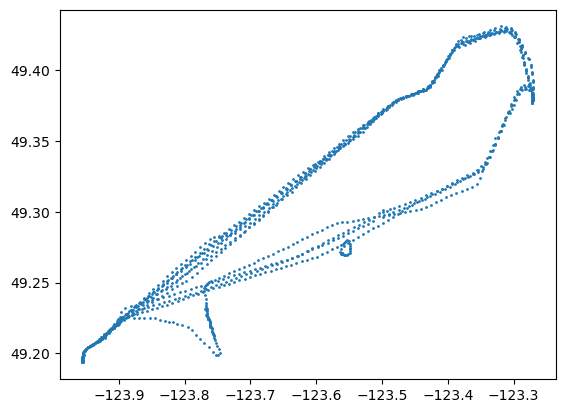

In [34]:
samples = reroute
plt.scatter(df[df.trip_id.isin(samples)].LONGITUDE, df[df.trip_id.isin(samples)].LATITUDE, s=1)

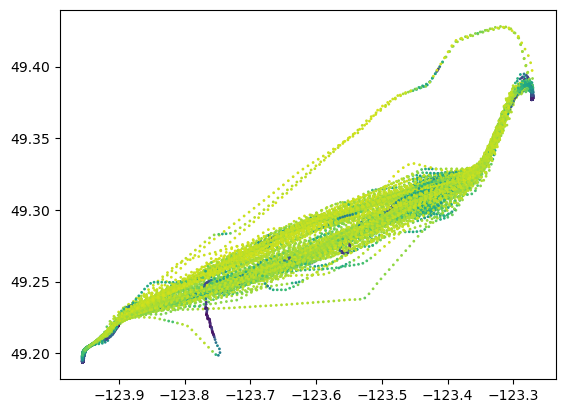

In [35]:
samples = reduce_speed
plt.scatter(df[df.trip_id.isin(samples)].LONGITUDE, df[df.trip_id.isin(samples)].LATITUDE, c = df[df.trip_id.isin(samples)].STW, s=1)

In [ ]:
df.to_csv("../../feature1.csv", index=False)

In [31]:
df.columns

Index(['Dati', 'Time', 'DEPTH', 'ENGINE_1_FLOWTEMPA',
       'ENGINE_1_FUEL_CONSUMPTION', 'ENGINE_2_FLOWTEMPA',
       'ENGINE_2_FUEL_CONSUMPTION', 'HEADING', 'LATITUDE', 'LONGITUDE',
       'PITCH_1', 'PITCH_2', 'POWER_1', 'POWER_2', 'SOG', 'SOG_SPEEDLOG_LONG',
       'SOG_SPEEDLOG_TRANS', 'SPEED_1', 'SPEED_2', 'STW', 'THRUST_1',
       'THRUST_2', 'TORQUE_1', 'TORQUE_2', 'WIND_ANGLE', 'WIND_SPEED',
       'WIND_ANGLE_TRUE', 'WIND_SPEED_TRUE', 'trip_id', 'MODE', 'datetime',
       'season', 'weekday', 'current', 'direction', 'pressure', 'rain',
       'snowfall', 'weathercode', 'is_weekday', 'effective_wind_factor',
       'effective_wind', 'resist_ratio1', 'resist_ratio2', 'adversarial'],
      dtype='object')